In [1]:
#This file uses an FFT to invert the Fourier transform of the hypoexponential distribution
import math
from scipy import integrate
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import sinc
from scipy import stats
from scipy.interpolate import interp1d

In [7]:
numberOfVars = int(6)        #the number of variables added
fftEvaluationMax = int(1e1)   #the maximum point the characteristic function is sampled at when computing its FFT
fftEvaluations = int(1e3)     #the number of samples of the characteristic function taken

lscale=np.random.exponential(scale=1,size=numberOfVars) #chooses scale parameters
sum_variance=np.sum([2*lscale[i]**(-2) for i in range(numberOfVars)])
fftEvaluationWidth = 2 * fftEvaluationMax / fftEvaluations  
#the width of the sampling of the
#characteristic function of the sum for the purposes of FFT

print("ADDING "+str(numberOfVars)+" VARIABLES")
if(numberOfVars <= 0 or fftEvaluationMax <= 0 or fftEvaluations <= 0):
    print("INVALID INPUT")


ADDING 6 VARIABLES


In [8]:
#takes the product of individual characteristic functions to yield characteristic of the sum
def hypoexponential_fourier_transform(t):
    return np.prod([lscale[i]/(lscale[i]-1.0j*t) for i in range(numberOfVars)])
def bihypoexponential_fourier_transform(t):
    return hypoexponential_fourier_transform(t)*hypoexponential_fourier_transform(-t)
def comparison_gaussian(x):
    return ((math.tau*sum_variance)**(-1/2)*np.exp(-x**2/(2*sum_variance)))
def pure_gaussian(x):
    return math.tau**(-1/2)*np.exp(-x**2)
def fft1(x):
    return np.fft.fft(np.fft.fftshift(x))

In [9]:
def bihypoexponential_fourier_outputs(evalMax, evalWidth):
    return [bihypoexponential_fourier_transform(-evalMax+i*evalWidth) 
            for i in range(round(2*(evalMax/evalWidth)))]

def unrestricted_output_xaxis(evalWidth,evaluations):
    return np.linspace(-1,1,evaluations)

def output_xaxis(evalMax,evaluations):
    return np.linspace(math.floor(-min(evalMax,3*math.sqrt(sum_variance))), math.floor(max(evalMax,3*math.sqrt(sum_variance))),num = math.floor(evaluations))

def bihypoexponential_fourier_outputs_trunc(evalMax, evaluations,evalWidth):
    return [bihypoexponential_fourier_transform(-evalMax+i*evalWidth) 
            for i in range(math.floor(-0.5*len(output_xaxis_trunc(evalMax,evaluations,evalWidth))),math.floor(0.5*len(output_xaxis_trunc(evalMax,evaluations,evalWidth))))]
    

#print(numpy.fft.fft(biexponential_fourier_outputs(fftEvaluationMax, fftEvaluationWidth)))

Area under fourier transform: (6.283185397898856-7.185009904207482e-15j)


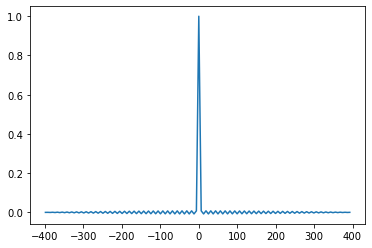

In [10]:
"""
Understand FFT normalization and scale
"""
N = 128
assert np.amax(np.fft.fft(np.ones(N))) == N # This is equiv to sum on phase times amp
assert np.amax(np.fft.ifft(np.ones(N))) == 1 # This is 1/N times sum on phase times amp

def t_from_x(x):
    """
    Get corresponding fourier sample points assuming even spacing
    """
    N = len(x)
    dx = x[1] - x[0]
    t = np.arange(-1 / (2 * dx), 1 / (2 * dx), 1 / (N * dx)) * math.tau
    return(t)

def cont_ft(x, t, f, mode):
    """
    Perform a continuous fourier transform the slow way (for checking answers)
    
    Args:
        x: Sample points in density domain
        t: Sample points in characteristic function domain
        f: Function to transform, evaluated at each of the samples
        mode: Direction of the transform
    """
    if mode == "dens_to_char":
        exp = np.exp(1.0j * np.outer(t, x))
        prefac = 1
        d = x
    elif mode == "char_to_dens":
        exp = np.exp(-1.0j * np.outer(x, t))
        prefac = 1 / math.tau
        d = t
    else:
        raise ValueError(f"'{mode}' is not a valid mode")
    
    integr = prefac * exp * f
    fhat = np.trapz(integr, d, axis=1)
    
    return(fhat)

x = np.linspace(-0.5, 0.5, num=N)
t = t_from_x(x)
f = np.ones(N)

fhat = cont_ft(x, t, f, "dens_to_char")

plt.plot(t, np.real(fhat))
print(f"Area under fourier transform: {np.trapz(fhat, t)}") # Should be approx tau

Check that it recovers a Gaussian

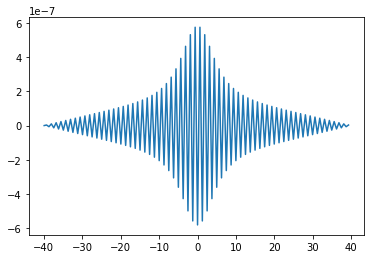

In [6]:
x = np.linspace(-5, 5, num=128)
t = t_from_x(x)
f = stats.norm.pdf(x)
fhat = cont_ft(x, t, f, "dens_to_char")

plt.plot(t, np.real(fhat) - stats.norm.pdf(t) * np.sqrt(math.tau)) # Should have small oscillations due to the clipped domain

### Oscillations are undesirable if we want accurate confidence estimates, but may be unavoidable in a discrete setting. The next couple cells try an FFT implementation

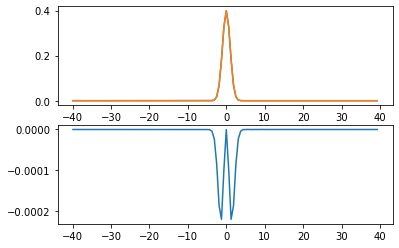

In [11]:
def fft_cont(t, fhat):
    """
    Only go from characteristic function to density. Assumes middle of t is 0.
    """
    N = len(t)
    fhat_shift = np.fft.fftshift(fhat)
    tfreq = t / math.tau # FFT assumes 2pi in exponent
    dtfreq = tfreq[1] - tfreq[0]
    x_shift = np.fft.fftfreq(N, dtfreq)
    
    x = np.fft.fftshift(x_shift)
    f_shift = np.fft.fft(fhat_shift) * dtfreq
    f = np.fft.fftshift(f_shift)
    
    return(x, f)

t = np.linspace(-5, 5, num=128)
fhat = stats.norm.pdf(t) * np.sqrt(math.tau)

x, f = fft_cont(t, fhat)

fig, ax = plt.subplots(nrows=2)
ax[0].plot(x, np.array([np.real(f), stats.norm.pdf(x)]).T) # Nearly exact overlap, bottom shows residual
ax[1].plot(x, np.real(f) - stats.norm.pdf(x)) # Some weird small shit going on near the origin but otherwise looks good

### Test on bihyp exp

Trapezoidal rule of 1 Lambda case is (0.999999999145061+6.505213034920915e-19j)
Trapezoidal rule of var of 1 Lambda case is (1.9999988534701918+3.305287596154111e-16j)
Trapezoidal rule of 5 Lambda case is (0.9999999999594953-1.161596499318416e-18j)
Trapezoidal rule of var of 5 Lambda case is (9.999999948307758+4.2760323205199317e-17j)


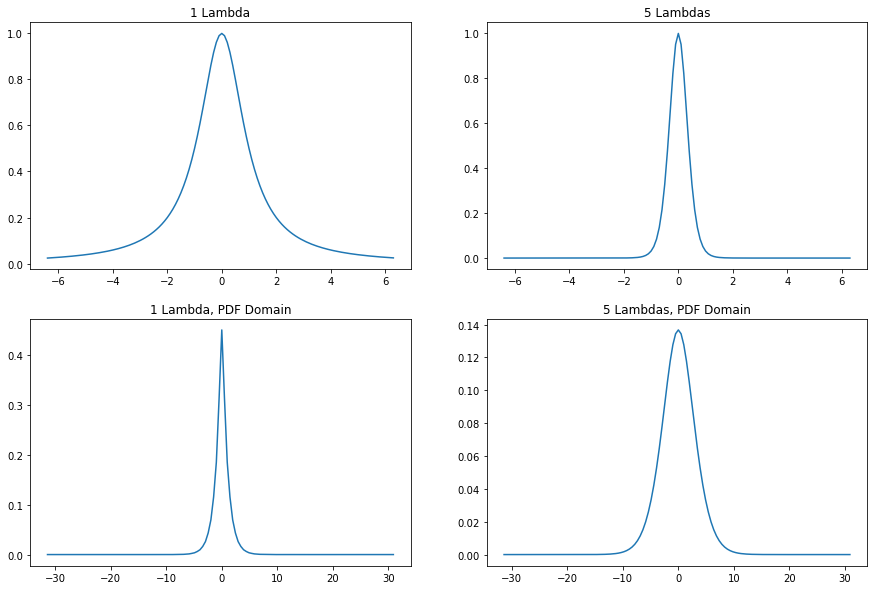

In [12]:


def bihyp_exp_cf(t, lams, norm='sum'):
    N = np.logical_not(np.isinf(lams)).sum(axis=0)
    if norm == 'sum':
        lams = 1 * lams # Do not touch the lambdas
    elif norm == "avg":
        lams = N * lams
    elif norm == "z-score":
        lams = np.sqrt(N) * lams
    else:
        raise ValueError("Only valid norms are 'sum', 'avg', and 'z-score'.")
    
    cf = np.prod(1 / (1 + t**2 / lams**2) , axis=0)
    return(cf)

def do_print(x, f, msg):
    integ = np.trapz(f, x)
    print(f"{msg} {integ}")
    return None

def four_panel_comp(norm='sum', print_norm=True, print_var=True, lam_use=None):

    t = np.arange(-6.4, 6.4, 0.1)
    lams = np.ones(1)
    fhat = np.zeros(len(t))
    for t_ind in range(len(t)):
        fhat[t_ind] = bihyp_exp_cf(t[t_ind], lams, norm=norm)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    ax[0, 0].plot(t, fhat)
    ax[0, 0].set_title("1 Lambda")
    x, f = fft_cont(t, fhat)
    if print_norm:
        do_print(x, f, "Trapezoidal rule of 1 Lambda case is")
    if print_var:
        do_print(x, x**2 * f, "Trapezoidal rule of var of 1 Lambda case is")
    ax[1, 0].plot(x, np.real(f))
    ax[1, 0].set_title("1 Lambda, PDF Domain")

    if lam_use is None:
        lams = np.ones(5)
    else:
        lams = lam_use
    fhat = np.zeros(len(t))
    for t_ind in range(len(t)):
        fhat[t_ind] = bihyp_exp_cf(t[t_ind], lams, norm=norm)    

    ax[0, 1].plot(t, fhat)
    ax[0, 1].set_title("5 Lambdas")
    x, f = fft_cont(t, fhat)
    if print_norm:
        do_print(x, f, "Trapezoidal rule of 5 Lambda case is")
    if print_var:
        do_print(x, x**2 * f, "Trapezoidal rule of var of 5 Lambda case is")
    ax[1, 1].plot(x, np.real(f))
    ax[1, 1].set_title("5 Lambdas, PDF Domain")
    
    return None

four_panel_comp()

Trapezoidal rule of 1 Lambda case is (0.999999999145061+6.505213034920915e-19j)
Trapezoidal rule of var of 1 Lambda case is (1.9999988534701918+3.305287596154111e-16j)
Trapezoidal rule of 5 Lambda case is (0.9999999991098137+2.4936649967167588e-18j)
Trapezoidal rule of var of 5 Lambda case is (0.39999880551942507+3.9509381175993635e-15j)


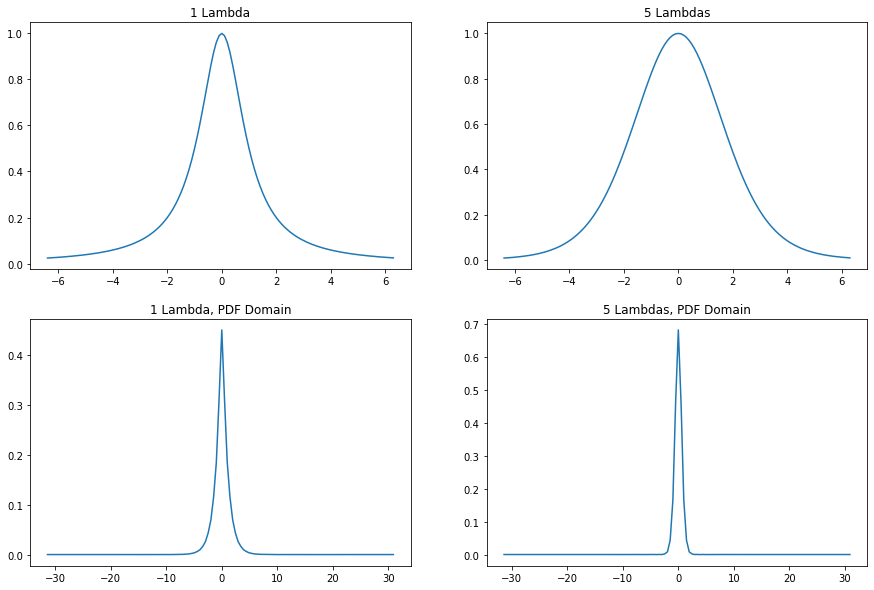

In [31]:
four_panel_comp(norm='avg')

Trapezoidal rule of 1 Lambda case is (0.999999999145061+6.505213034920915e-19j)
Trapezoidal rule of var of 1 Lambda case is (1.9999988534701918+3.305287596154111e-16j)
Trapezoidal rule of 5 Lambda case is (0.9999999999975226+5.065257024580716e-19j)
Trapezoidal rule of var of 5 Lambda case is (1.9999999966726059-2.5286555508788514e-16j)


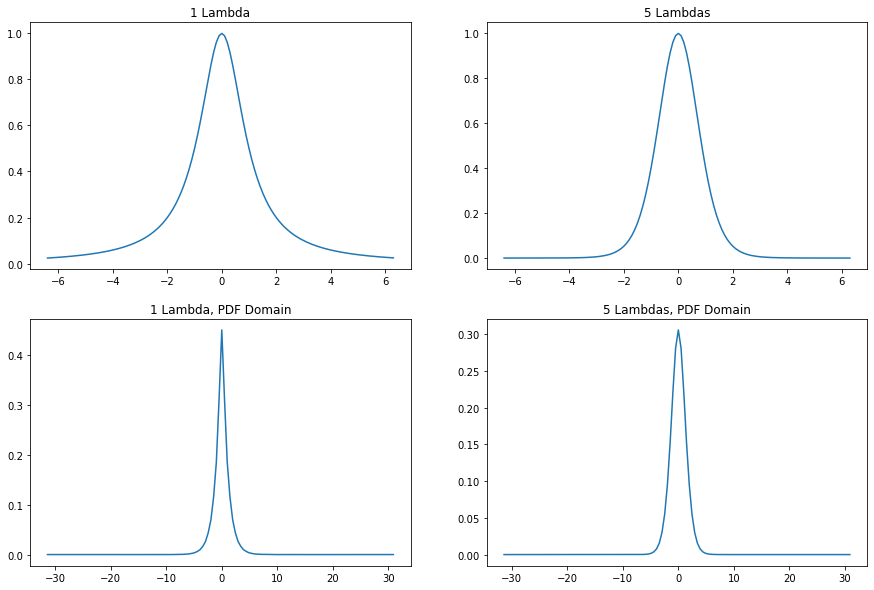

In [32]:
four_panel_comp(norm='z-score')

Expected var of 5 case is 2.9272222222222224
Trapezoidal rule of 1 Lambda case is (0.999999999145061+6.505213034920915e-19j)
Trapezoidal rule of var of 1 Lambda case is (1.9999988534701918+3.305287596154111e-16j)
Trapezoidal rule of 5 Lambda case is (0.999999999993967-2.80876125309526e-18j)
Trapezoidal rule of var of 5 Lambda case is (2.9272222141237556+5.6230145549456915e-15j)


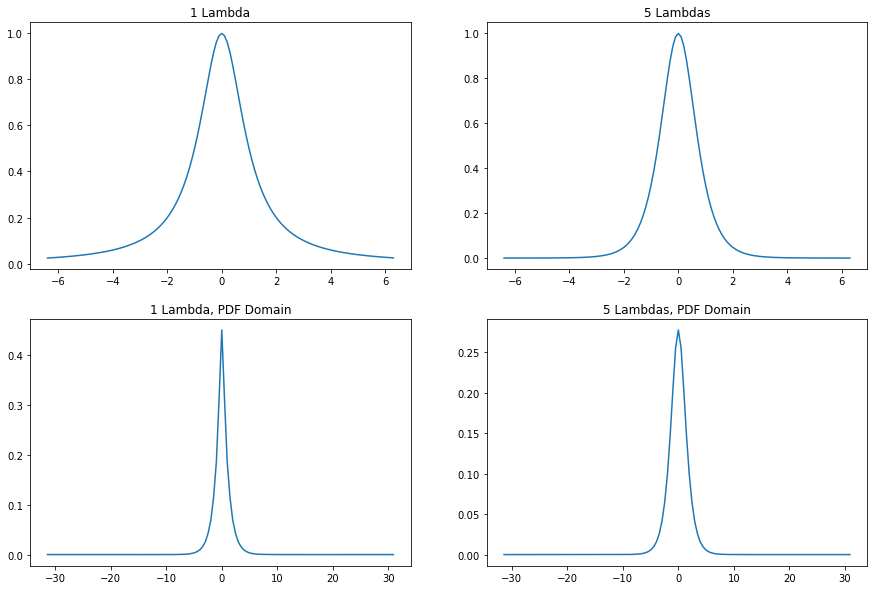

In [34]:
lam_use = np.arange(1, 6)
exp_var = np.sum(1 / lam_use**2) * 2 
print(f"Expected var of 5 case is {exp_var}")
four_panel_comp(norm='sum', lam_use = np.arange(1, 6))


Expected var of 5 case is 0.5854444444444444
Trapezoidal rule of 1 Lambda case is (0.999999999145061+6.505213034920915e-19j)
Trapezoidal rule of var of 1 Lambda case is (1.9999988534701918+3.305287596154111e-16j)
Trapezoidal rule of 5 Lambda case is (0.9999999991035846-4.119968255444325e-18j)
Trapezoidal rule of var of 5 Lambda case is (0.5854432418472806+3.1414208838015344e-16j)


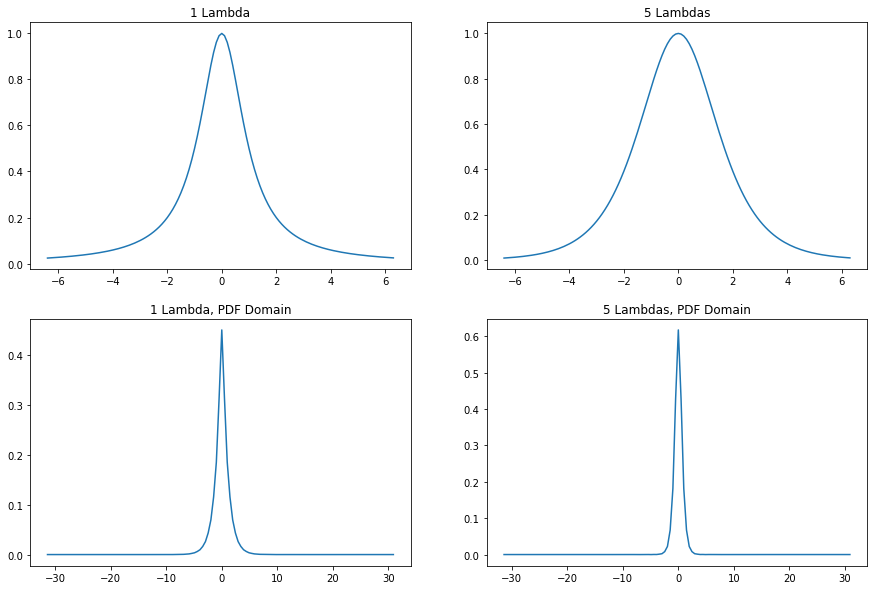

In [35]:
lam_use = np.arange(1, 6)
exp_var = np.sum(1 / lam_use**2) * 2 / 5
print(f"Expected var of 5 case is {exp_var}")
four_panel_comp(norm='z-score', lam_use = np.arange(1, 6))

### This next plot shows some wigglies in the bottom right, probably because the upper-right got chopped too far in. Just shows we need ot be careful about sizing the window in the t-domain.

Expected var of 5 case is 0.1170888888888889
Trapezoidal rule of 1 Lambda case is (0.999999999145061+6.505213034920915e-19j)
Trapezoidal rule of var of 1 Lambda case is (1.9999988534701918+3.305287596154111e-16j)
Trapezoidal rule of 5 Lambda case is (0.9999999913131489+4.770489558936235e-18j)
Trapezoidal rule of var of 5 Lambda case is (0.11707724075205701+4.627977376372953e-16j)


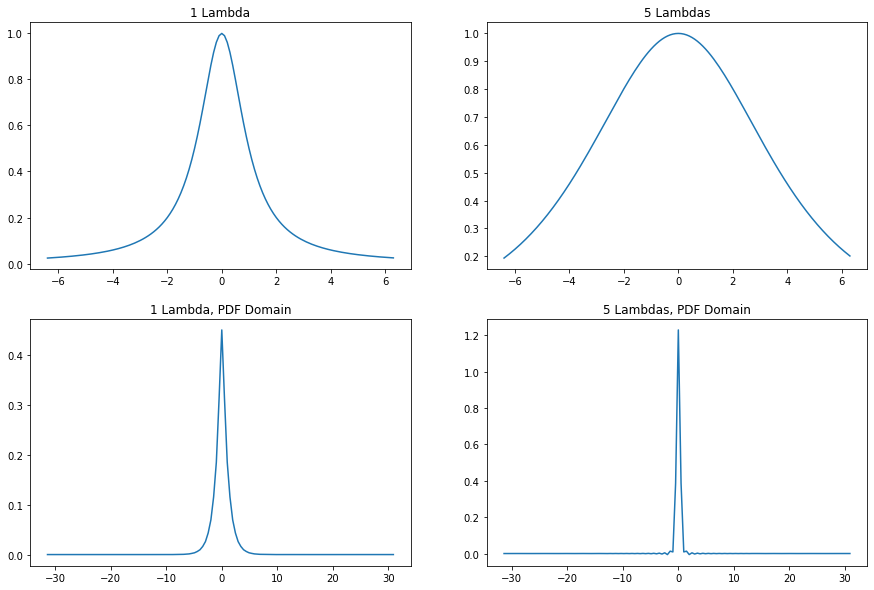

In [37]:
lam_use = np.arange(1, 6)
exp_var = np.sum(1 / lam_use**2) * 2 / 5**2
print(f"Expected var of 5 case is {exp_var}")
four_panel_comp(norm='avg', lam_use = np.arange(1, 6))

# Confidence intervals of biexponentials

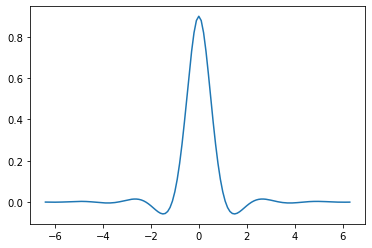

In [14]:
def conf_integ(t, lams, x0=2 * np.sqrt(2), norm='z-score'):
    integ = bihyp_exp_cf(t, lams, norm=norm) * sinc(x0 * t / np.pi) * x0 / np.pi
    return(integ)

t = np.arange(-6.4, 6.4, 0.1)
integ = [conf_integ(tp, np.array([1, np.inf])) for tp in t] # Can chain inf's on - useful computational trick for later to avoid for loops
plt.plot(t, integ)


In [15]:
def get_cdf(lams, vals=np.arange(0, 0.11, 0.01), mode='avg', limit=200):

    y = []
    num_ninf = np.logical_not(np.isinf(lams)).sum(axis=0)
    var = 2 * np.sum(1 / lams**2, axis=0) 
    if mode == 'avg':# infs mean they're not actually summed
        var = var / num_ninf**2
    elif mode == 'z-score':
        var = var / num_ninf
    std = np.sqrt(var)
    for val in vals:
        integral = integrate.quad_vec(conf_integ, 0, np.inf, args=(lams, 2 * std * (1 + val), mode),
                                      limit=limit)
        y.append(0.5 + integral[0])
    if np.all(np.array(y) < 0.5):
        print(lams)
        raise ValueError("Bad lams by fluke")
    return(1 + vals, np.array(y), std)

def invert(x, y):
    xp = stats.norm.cdf(2)
    if len(y.shape) > 1:
        inv = []
        for y_use in np.array(y).T:
            interp = interp1d(y_use, x)
            try:
                inv_now = interp(xp)
            except ValueError as err:
                print(stats.norm.cdf(2))
                print(y_use, x)
                raise err
            inv.append(inv_now)
    else:
        interp = interp1d(y, x)
        try:
            inv = interp(xp)
        except ValueError as err:
            print(stats.norm.cdf(2))
            print(y, x)
            raise err
    
    return(np.array(inv))
    
def get_conf_rat(lams, mode='avg', limit=200):
    x, y, std = get_cdf(lams, mode=mode, limit=limit)
    inv = invert(x, y)
    
    return(inv, y, std)
lams = 1000 * np.ones([1, 2])
print(get_cdf(lams))
print(get_conf_rat(lams)[0])

(array([1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ]), array([[0.97044714, 0.97044714],
       [0.9712713 , 0.9712713 ],
       [0.9720725 , 0.9720725 ],
       [0.97285132, 0.97285132],
       [0.97360845, 0.97360845],
       [0.97434445, 0.97434445],
       [0.97505994, 0.97505994],
       [0.97575538, 0.97575538],
       [0.97643159, 0.97643159],
       [0.97708887, 0.97708887],
       [0.97772783, 0.97772783]]), array([0.00141421, 0.00141421]))
[1.09251972 1.09251972]


Draw lambdas from a power law, add gaussian noise to power law to simulate error in variance estimate, normalize by erroneous lambdas, see how the Gaussianity behaves (also see how it behaves without normalizing by lambdas)

In [199]:
%%timeit
#lams = np.random.uniform(low=1, high=2, size=[10, 10])
lams = np.ones([100, 100 * 100])
inv = get_conf_rat(lams)

29.6 s ± 781 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [201]:
%%timeit
#lams = np.random.uniform(low=1, high=2, size=[10, 10])
lams = np.ones([10, 10 * 100])
inv = get_conf_rat(lams)

358 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [204]:
%%timeit
#lams = np.random.uniform(low=1, high=2, size=[10, 10])
lams = np.random.uniform([10, 10 * 100])
inv = get_conf_rat(lams)

1.52 s ± 389 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


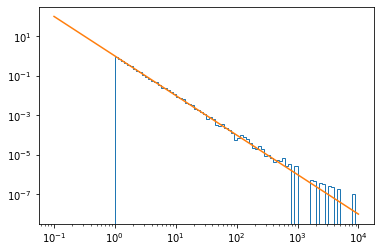

In [16]:
def get_plaw_samples(minlam, maxlam, plind, size):
    if plind == 1:
        raise ValueError("plind must not equal 1")
    alpha = plind - 1
    
    uni = np.random.uniform(size=size)
    plaw = minlam * (1 - (1 - (minlam/maxlam) ** alpha) * uni)**(-1 / alpha)
    return(plaw)

P = get_plaw_samples(1, 1e4, 2, int(1e4))
_, bins, _ = plt.hist(P, bins=np.logspace(-1, 4, num=101), log=True, density=True, histtype='step')
plt.plot(bins, 1 / bins**2)
plt.xscale("log")


In [17]:
def make_triangle(seq):
    """
    Make an upper triangular matrix out of a sequence, with np.inf in the lower triangle.
    """
    lseq = len(seq)
    arr = np.repeat(seq[:, np.newaxis], lseq, axis=1)
    tri_arr = np.triu(arr)
    tri_arr[tri_arr == 0] = np.inf
    
    return(tri_arr)

def plaw_conf_sim(plind = 2, minlam = 1, maxlam=1e3, Nsum = 100, Nreal = 100, tri=True, limit=200):

    Nsum = int(Nsum)
    Nreal = int(Nreal)
    drawshape = [Nsum, Nreal]
    lams = get_plaw_samples(minlam, maxlam, plind, drawshape)
    if tri:
        tri_lams = np.zeros([Nsum, Nsum * Nreal])
        for real_ind in range(Nreal):
            tri_lams[:, real_ind * Nsum: (real_ind + 1) * Nsum] = make_triangle(lams[:, real_ind])
        lams_use = tri_lams
    else:
        lams_use = lams
    
    confs, y, stds = get_conf_rat(lams_use, limit=limit)
    if np.any(confs > 1.1):
        print(lams_use[:, confs > 1.1][:, 0])
        print(stds[confs > 1.1][0])
        print(y[:, confs > 1.1][0, 0])
        
    return(confs)

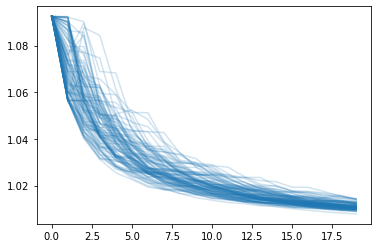

In [182]:
confs = plaw_conf_sim(plind=2, Nsum=20, tri=True)
conf_res = confs.reshape([100, 20])
for conf_ind in range(100):
    plt.plot(conf_res[conf_ind, :], color='tab:blue', alpha=0.2)

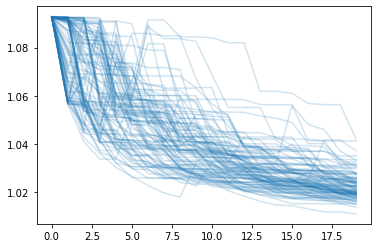

In [188]:
confs = plaw_conf_sim(plind=1.2, Nsum=20, tri=True, limit=200)
conf_res = confs.reshape([100, 20])
for conf_ind in range(100):
    plt.plot(conf_res[conf_ind, :], color='tab:blue', alpha=0.2)

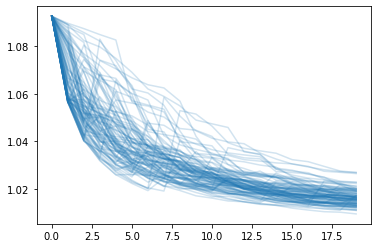

In [223]:
confs = plaw_conf_sim(plind=0.3, Nsum=20, tri=True, limit=200, maxlam=1e1)
conf_res = confs.reshape([100, 20])
for conf_ind in range(100):
    plt.plot(conf_res[conf_ind, :], color='tab:blue', alpha=0.2)

In [200]:
%timeit plaw_conf_sim(plind=0.3, Nsum=10, tri=True, limit=200)

10.4 s ± 1.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [203]:
%timeit plaw_conf_sim(plind=2, Nsum=20, tri=True, limit=200)

24.6 s ± 1.24 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [206]:
%%timeit

Nsum = int(20)
Nreal = int(100)
drawshape = [Nsum, Nreal]
lams = get_plaw_samples(1, 1000, 2, drawshape)

tri_lams = np.zeros([Nsum, Nsum * Nreal])
for real_ind in range(Nreal):
    tri_lams[:, real_ind * Nsum: (real_ind + 1) * Nsum] = make_triangle(lams[:, real_ind])
lams_use = tri_lams
confs, y, stds = get_conf_rat(lams_use, limit=200)

23.1 s ± 878 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [233]:
for plind in [0.4, 1.2, 2]:
    for maxlam in [10, 100]:
        confs = plaw_conf_sim(plind=plind, Nsum=50, tri=True, limit=200, maxlam=maxlam)
        np.save(f'confs_plind_{plind}_maxlam_{maxlam}.npy', confs)


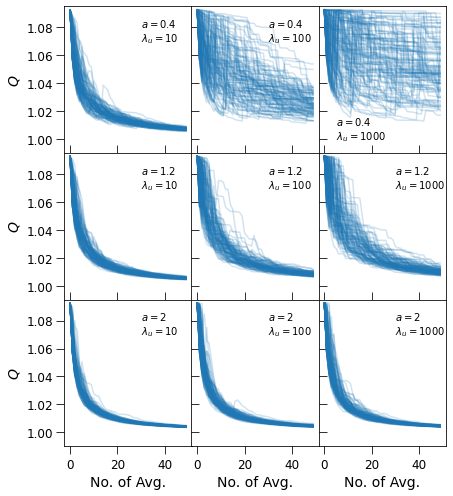

In [2]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(6.5, 7), ncols=3, nrows=3)
for pind, plind in enumerate([0.4, 1.2, 2]):
    for mind, maxlam in enumerate([10, 100, 1000]):
        confs = np.load(f'confs_plind_{plind}_maxlam_{maxlam}.npy')
        confs = np.reshape(confs, [100, 50])
        ax[pind, mind].set_ylim(0.99, 1.095)
        ax[pind, mind].plot(confs.T, alpha=0.2, color='tab:blue')
        if mind == 0:
            ax[pind, mind].set_ylabel("$Q$", fontsize=14)
        else:
            ax[pind, mind].tick_params(axis='y', direction='in')
            ax[pind, mind].set_yticklabels([])
        if pind == 2:
            ax[pind, mind].set_xlabel("No. of Avg.", fontsize=14)
        else:
            ax[pind, mind].tick_params(axis='x', direction='in')
            ax[pind, mind].set_xticklabels([])
        ax[pind, mind].tick_params(size=8, labelsize=12)
        label = f"$a={plind}$\n$\lambda_u={maxlam}$"
        #line = Line2D([], [], color='tab:blue')
        #ax[pind, mind].legend([line], [label])
        if pind == 0 and mind == 2:
            ax[pind, mind].text(5, 1.00, label)
        else:
            ax[pind, mind].text(30, 1.07, label)
fig.tight_layout(h_pad=0, w_pad=-0.5)
fig.savefig("nine_panel_conf_rat.pdf")

In [18]:
lams = get_plaw_samples(1, 1000, 0.4, [50, 100])
vals = np.arange(-1, 5, 0.01)
x, y, std = get_cdf(lams, vals=vals, mode='avg')
print(y.shape)

(600, 100)


In [19]:
yref = np.flip(1 - y[1:])
xcopy = -np.flip(x[1:])

xuse = np.append(xcopy, x)
yuse = np.append(yref, y, axis=0)
print(xuse)
xmid = 0.5 * (xuse[1:] + xuse[:-1])

[-5.99 -5.98 -5.97 ...  5.97  5.98  5.99]


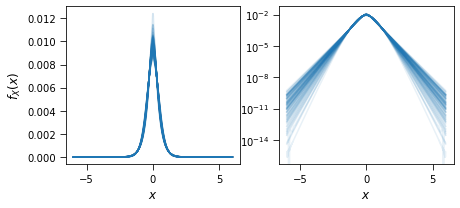

In [33]:
fig, ax = plt.subplots(figsize=(6.5, 3), ncols=2)
for ax_ob in ax:
    ax_ob.plot(xmid, np.diff(yuse, axis=0), color='tab:blue', alpha=0.1)
    ax_ob.set_xlabel("$x$", fontsize=12)
    ax_ob.tick_params(size=6, labelsize=10)
ax[0].set_ylabel("$f_X(x)$", fontsize=12)
ax[1].set_yscale("log")

fig.tight_layout(w_pad=0)
plt.savefig("double_exp_collect.pdf")

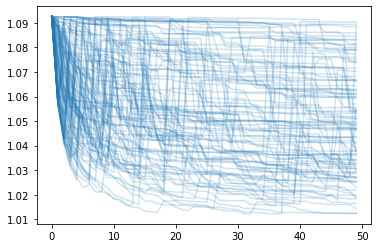

In [209]:
conf_res = confs.reshape([100, 50])
for conf_ind in range(100):
    plt.plot(conf_res[conf_ind, :], color='tab:blue', alpha=0.2)

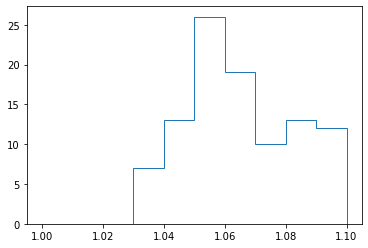

In [19]:
for plind 

/var/folders/44/y1tcl2p954sfxxppc84pk_kr0000gn/T/ipykernel_50366/3128367818.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  y.append(0.5 + integrate.quad(conf_integ, 0, np.inf, args=(lams, 2 * std * (1 + val)),


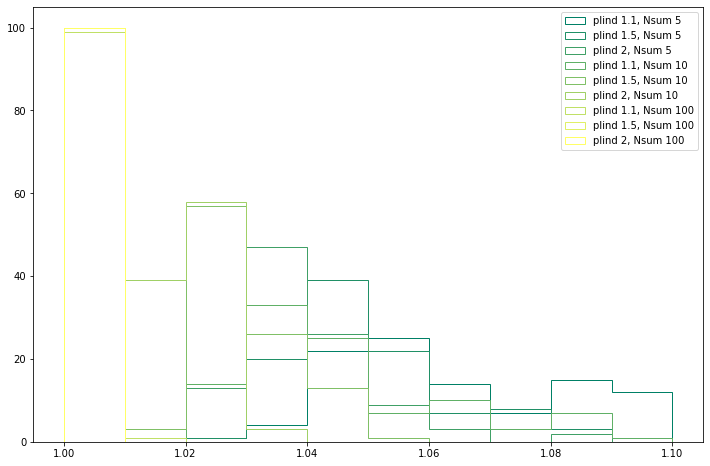

In [25]:
import matplotlib as mpl
plt.figure(figsize=(12, 8))
start = 0.0
stop = 1.0
number_of_lines= 9
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ mpl.cm.summer(x) for x in cm_subsection ]

for ns_ind, Nsum in enumerate([5, 10, 100]):
    for pl_ind, plind in enumerate([1.1, 1.5, 2]):
        confs = plaw_conf_sim(plind=plind, Nsum=Nsum)
        plt.hist(confs, label=f"plind {plind}, Nsum {Nsum}", color=colors[3 * ns_ind + pl_ind], **hist_kwargs)
        plt.legend()

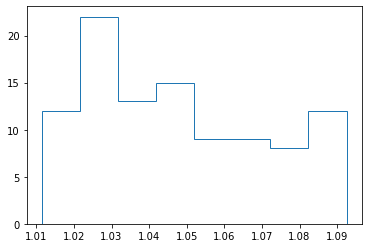

In [43]:
invs = np.array(invs)
_, _, _ = plt.hist(invs, bins="auto", histtype="step")

In [160]:
stats.laplace.cdf(2 * np.sqrt(2) * 1) / stats.norm.cdf(2)

0.9930388925543061

In [128]:
stats.norm.isf((1 - 0.9545)/2)

2.0000024438996036

0.01


/Users/mike_e_dubs/anaconda/envs/ssins/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


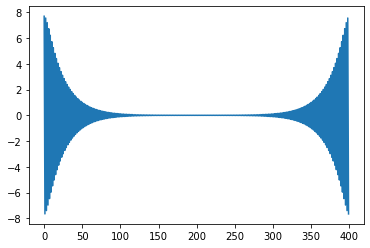

In [36]:
print(1e-2)
plt.plot(np.fft.fft(bihypoexponential_fourier_outputs(2,1e-2)))

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


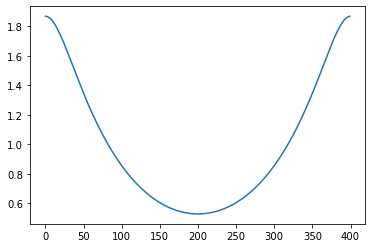

In [52]:
plt.plot(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(2,1e-2))))

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


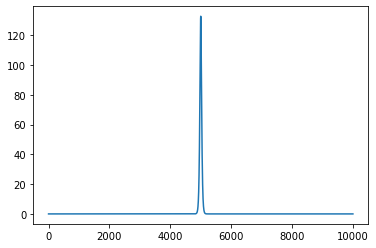

In [7]:
plt.plot(np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth)))))

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


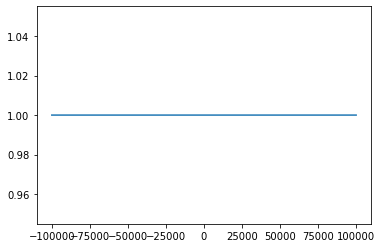

In [19]:
plt.plot(output_xaxis(fftEvaluationMax,fftEvaluations,fftEvaluationWidth)/math.sqrt(sum_variance), np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth)))))

In [39]:
print(output_xaxis(fftEvaluationMax,fftEvaluations)[:10])

[-140.         -138.99858999 -137.99717997 -136.99576996 -135.99435994
 -134.99294993 -133.99153992 -132.9901299  -131.98871989 -130.98730987]


In [39]:
print(sum_variance)

46.89093941706658


In [41]:
print(output_xaxis(fftEvaluationMax,fftEvaluations)[:10]/math.sqrt(sum_variance))

[-3.00062734 -2.97916407 -2.9577008  -2.93623752 -2.91477425 -2.89331098
 -2.8718477  -2.85038443 -2.82892116 -2.80745788]


In [38]:
outputs = np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth))))
print(outputs[:10])

[-5.09260602e-15-4.40290602e-17j  4.34401863e-15-1.36856019e-16j
 -4.89126968e-15-8.97420120e-16j  3.41805577e-15-4.51159320e-16j
 -5.12285526e-15-1.63992083e-16j  4.97497009e-15-2.14663680e-16j
 -4.98602895e-15-6.79301197e-16j  3.66330230e-15-4.79269167e-16j
 -5.14692455e-15-5.54233870e-16j  4.75400969e-15+2.22312871e-16j]


In [44]:
print(len(outputs))

100000


In [40]:
print(outputs[49950:50050])

[]


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


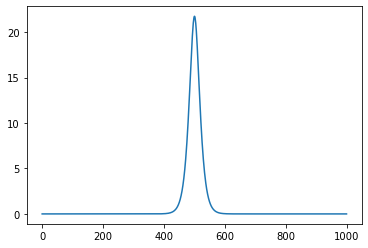

In [42]:
plt.plot(outputs)

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


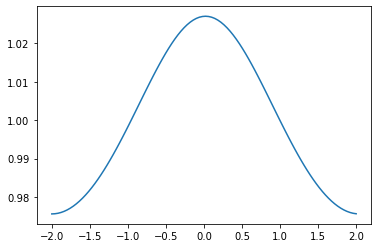

In [58]:
plt.plot(unrestricted_output_xaxis(fftEvaluationMax,fftEvaluations),np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth)))))

In [53]:
outputs2 = np.multiply(np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth)))),fftEvaluationWidth)

In [89]:
#plt.plot(unrestricted_output_xaxis(fftEvaluationMax,fftEvaluations),outputs2-1)

gaussianoutputs=[]
for i in range(len(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations))):
    gaussianoutputs.append(comparison_gaussian(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations)[i]))
    

#plt.plot(unrestricted_output_xaxis(fftEvaluationMax,fftEvaluations),gaussianoutputs)

In [3]:
a = [ 1,2,3]
a.append(4)
print(a)
print(a*3)
print(3*a)
print(np.power(a,[2,2,2,2]))
print(np.ones(4))

[1, 2, 3, 4]
[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
[ 1  4  9 16]
[1. 1. 1. 1.]


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


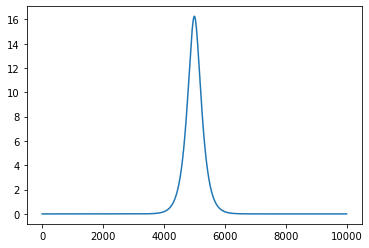

In [51]:
plt.plot(np.fft.fftshift(np.fft.fft(np.fft.fftshift(bihypoexponential_fourier_outputs(fftEvaluationMax,fftEvaluationWidth)))))

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


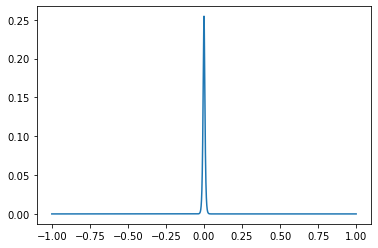

In [115]:
#plt.xlim((-3,3))
plt.plot(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),outputs2)
#plt.plot(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),comp_gauss_array2)
#plt.plot(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),gaussianoutputs)

In [10]:
print(sum_variance)

123.78376558350976


In [27]:
print(lscale)

[1.10540517 0.23672826 1.38364559 0.61323251 0.37748081 0.04056269
 0.78970471 1.66549811 0.90537509 0.09810155 0.17203844 4.00080311
 0.40836623 6.10002302 1.46869121 1.05371547 0.36242556]


In [29]:
print(2*0.098**(-2))

208.2465639316951


In [35]:
print(1/fftEvaluationWidth)

500.0


In [87]:
print(np.sum(outputs2))

(9999.999999999998+3.2311742677852644e-27j)


In [39]:
print(np.var(outputs2))

23.84461499217335


In [40]:
(23.8/20)**2

1.4161

In [107]:
test_var=max(outputs2)**(-2)/math.tau
def comp_gauss_2(x):
    return (math.tau*test_var)**(-0.5)*np.exp(-0.5*x**2/test_var)
comp_gauss_array2=[]
for i in range(fftEvaluations):
    comp_gauss_array2.append(comp_gauss_2((unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations)[i])))
print(len(comp_gauss_array2))

10000


In [111]:
print(max(outputs2)**(-2)/math.tau)
print(sum_variance)

(0.0006020449211085417+0j)
135.7717564369972


In [112]:
print(sum_variance/max(outputs2)**(-2)/math.tau)

(5712.428834241259+0j)


In [113]:
print(1/fftEvaluationWidth)

500.0


In [73]:
print(np.sum(outputs))

(1000+0j)


In [13]:
print(np.var(outputs))

85.27919181057622


In [14]:
print(len(outputs))

10000


In [15]:
print(sum_variance/np.var(outputs))

1.451511945123268


In [16]:
print(fftEvaluationWidth)

0.002


In [45]:
print(max(outputs))

(21.755357414455723+0j)


In [18]:
print(outputs[5000])

(132.69796292857257+0j)


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


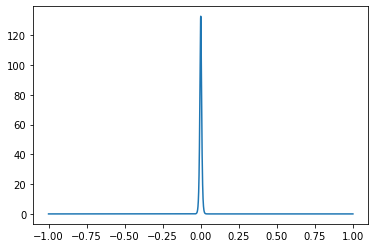

In [19]:
plt.plot(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),outputs)

In [48]:
#calculate the variance as obtained through FFT
fft_var = np.sum(np.multiply(np.power(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),2),outputs))

In [30]:
print(sum_variance/fft_var)
print(math.sqrt(sum_variance/fft_var))

(246.64160101865275-4.2637134698635305e-11j)
15.70482731578583
19.739208802178716


/var/folders/gj/__b576yx281fswz42qs0_sjm0000gn/T/ipykernel_4077/3256844612.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  print(math.sqrt(sum_variance/fft_var))


In [31]:
outputs2 = np.multiply(outputs,fftEvaluationWidth)

/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


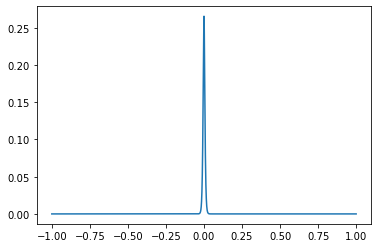

In [32]:
plt.plot(unrestricted_output_xaxis(fftEvaluationWidth,fftEvaluations),outputs2)

In [34]:
print((sum_variance*math.tau)**(-0.5))

0.03585735251394608


In [52]:
print(max(outputs)/(sum_variance*math.tau)**(-0.5))

(373.42262159329937+0j)


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


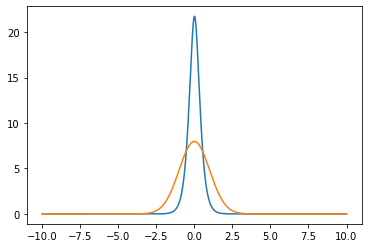

In [72]:
xaxis4 = np.linspace(-fftEvaluationMax,fftEvaluationMax,fftEvaluations)
plt.plot(xaxis4,outputs)
def comparison_gaussian_1(x):
    return ((math.tau)**(-1/2)*np.exp(-x**2/(2)))
#sn_pdf = scipy.stats.norm.pdf(xaxis4)
plt.plot(xaxis4,20*comparison_gaussian_1(xaxis4))

In [49]:
print(fft_var)

(1.9052267417918527-4.343104203054419e-15j)


In [50]:
fft_var2 = np.sum(np.multiply(np.power(np.linspace(-fftEvaluationMax,fftEvaluationMax,fftEvaluations),2),outputs))
print(fft_var2)

(190.52267417918512-4.3431042030546713e-13j)


In [51]:
print(4*sum_variance)

187.56375766826633


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


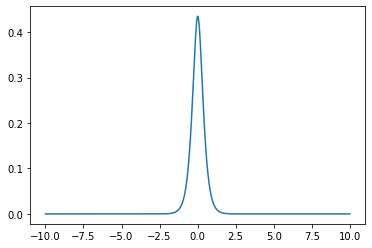

In [54]:
plt.plot(np.linspace(-fftEvaluationMax,fftEvaluationMax,fftEvaluations),outputs2)

In [57]:
bscale=[]
bscale_squares=[]
for i in range(numberOfVars): 
    bscale.append(1/lscale[i])
    bscale_squares.append(bscale[i]**2)
#these are the induced betas
    
pt_mean = np.sum(bscale)
pt_var = np.sum(bscale_squares)
#compute the mean and variance of the sum distribution

theta = np.zeros((numberOfVars,numberOfVars))
#initialize theta

for i in range(numberOfVars):
    theta[i,i]=-lscale[i]
    if(i<numberOfVars-1):
        theta[i,i+1]=lscale[i]
#defines the rate matrix
print(theta)


def projected_pdf(x):
    if(x>=0):
        return (-(np.sum(np.einsum('ij,jk',scipy.linalg.expm(x*theta),theta),axis=1)[0]))
    else:
        return 0

#the cdf and pdf in the matrix-exponential formulation


#another check

#now we just produce the graph

biexponential_outputs=[]

def projected_biexponential_pdf(x):
    result=integrate.quad(lambda y:projected_pdf(y)*projected_pdf(y-x),-20,20)    
    return(result[0])

[[-3.30016117  3.30016117  0.          0.          0.          0.        ]
 [ 0.         -2.12786946  2.12786946  0.          0.          0.        ]
 [ 0.          0.         -0.46629226  0.46629226  0.          0.        ]
 [ 0.          0.          0.         -0.6170008   0.6170008   0.        ]
 [ 0.          0.          0.          0.         -0.25508186  0.25508186]
 [ 0.          0.          0.          0.          0.         -1.3634309 ]]


hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!


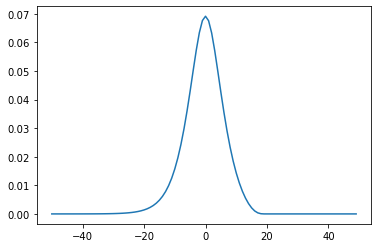

In [58]:
inputs=[]

pdf_outputs=[]

for i in range(100):
    inputs.append((-50+i))

    pdf_outputs.append(projected_pdf(inputs[i]))
    biexponential_outputs.append(projected_biexponential_pdf(inputs[i]))
    print("hi!")

#plt.plot(inputs,pdf_outputs)
plt.plot(inputs,biexponential_outputs)

In [59]:
print(projected_biexponential_pdf(0))

0.06910669586859539


/Users/jordanlbrown/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


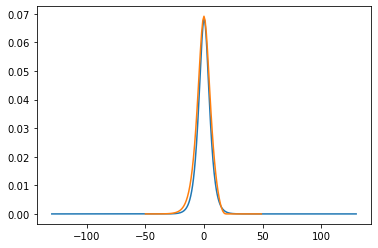

In [69]:
plt.plot(np.linspace(-13*fftEvaluationMax,13*fftEvaluationMax,fftEvaluations),outputs/320)
plt.plot(inputs,biexponential_outputs)

# Mike's Additions

In [321]:
-1/np.sqrt(2) * np.log(2*(1 - stats.norm.cdf(2))) / 2

1.0924931125455006